In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import scipy as sp
from IPython.display import Math, display

# Problem 1: Transformation Method for Normal Distribution

## part (a): Write a program to sample $p(x; \mu = 0, \sigma^2 = 1)$ using this approximation

In [2]:
def sampleNormalDist(npts):
    #declare constants of x
    a0, a1 = 2.30753, 0.27061
    b1, b2 = 0.99229, 0.04481
    
    u = np.random.random((npts, 1))
    t_less = np.sqrt(-2*np.log(u[u <= 0.5])) #geiven t-value for u <= 0.5
    t_great = np.sqrt(-2*np.log(1 - u[u > 0.5])) #given t-value for u > 0.5
    
    #formula for piecewise x based on which t
    x_less = ((a0 + a1*t_less) / (1 + b1*t_less + b2*t_less**2)) - t_less
    x_great = t_great - ((a0 + a1*t_great) / (1 + b1*t_great + b2*t_great**2))
    x = np.concatenate((x_less, x_great))
    return x

## part (b): Compare the histogram of these samples with the PDF

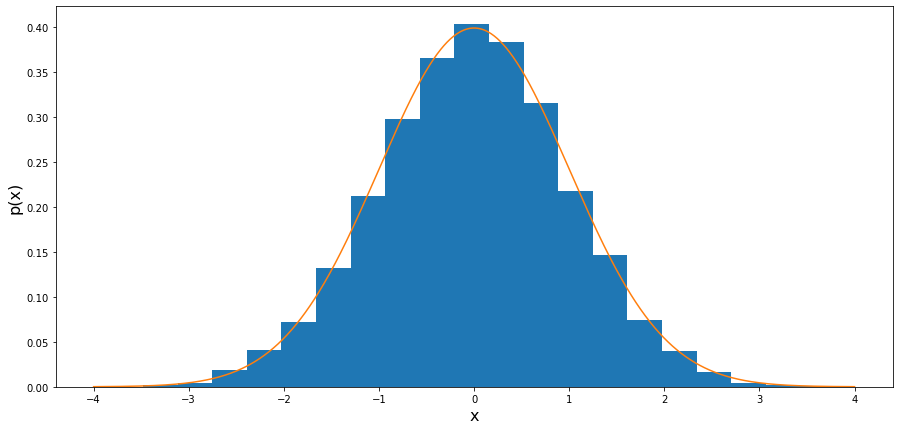

In [3]:
samples = 10**4
x = sampleNormalDist(samples)

plt.figure(figsize = (15, 7))
plt.hist(x, 20, density = True)

#overlay PDF
xi = np.linspace(-4., 4., 1000)
mu, sigma = 0.0, 1.0; fnorm =  1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5 * (xi - mu)**2 / sigma**2)
plt.plot(xi, fnorm)
plt.xlabel('x', fontsize = '16')
plt.ylabel('p(x)', fontsize = '16')
plt.show()

## part (c): Compute the mean and standard deviation of these samples

In [4]:
display(Math('\\mu =' + str(np.mean(x))))
display(Math('\\sigma =' + str(np.std(x))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Problem 2: Importance Sampling

In [5]:
import scipy.integrate as integrate
g = lambda theta: (theta / (1 + theta**2)) * np.exp(-0.5*(theta-1)**2) 
integrate.quad(g, -np.infty, np.infty)

(0.7235709525588703, 1.3758417147460515e-08)

## part (a): Use importance sampling with $n = 10^4$ samples drawn from the normal distribution to evaluate the integral
## part (b): Estimate the error $\sigma_I$ in the integral without resorting to multiple runs

In [6]:
def importanceSampling(mu, sigma, npts):
    x = 2 * sampleNormalDist(npts)
    f = (x / (1 + x**2)) * np.exp(-0.5 * (x-1)**2)
    p = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * (x - mu) ** 2 / sigma**2) 
    
    intg = np.mean(f / p)
    stdI = np.std(f / p) / np.sqrt(npts)
    
    return intg, stdI

estInt, estErr = importanceSampling(0, 2, samples)
display(Math('I \\approx ' + sy.latex(estInt) + '\\text{, with estimated error } \\sigma_{I} = ' + sy.latex(estErr)))

<IPython.core.display.Math object>

# Bayesian Inference

## part (a): Plot the prior and posterior distributions, and comment on the difference between them

In [42]:
def priorPoisson(a, b, isPlot = True):
    frac = b**a / sp.special.gamma(a)
    if isPlot:
        lam = np.linspace(0, 40, 1000)
        dist = frac * lam**(a-1) * np.exp(-b * lam)
        
        plt.figure(figsize = (11, 7))
        plt.plot(lam, dist, label = "prior")
        plt.xlabel('$\lambda$', fontsize = '14')
        plt.ylabel('p($\lambda$)', fontsize = '14')
        
def posteriorPoisson(a, b, k, isPlot = True):
    n = len(k)
    alpha = a + np.sum(k)
    beta = n + b
    frac = beta**alpha / sp.special.gamma(alpha)
    if isPlot:
        lam = np.linspace(0, 40, 1000)
        dist = frac * lam**(alpha-1) * np.exp(-beta * lam)
        
        plt.plot(lam, dist, label = "post")
        plt.legend(fontsize = 14)
        plt.title("Prior and Posterior Distributions", fontsize = '14')
        plt.xlabel('$\lambda$', fontsize = '14')
        plt.ylabel('p($\lambda|\mathbf{k}$)', fontsize = '14')

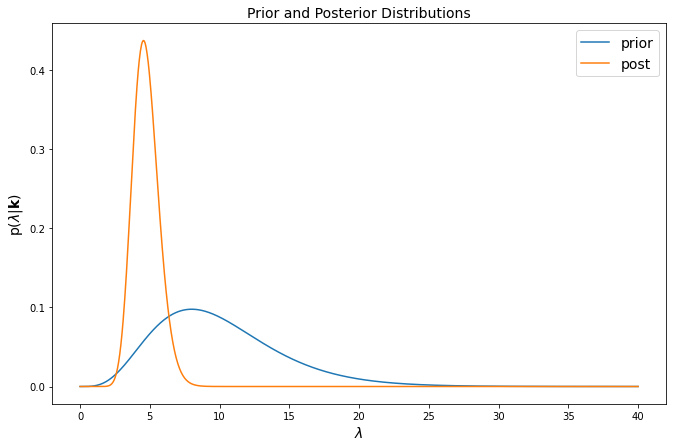

In [57]:
a, b = 5, 0.5
k = np.array([6, 2, 3, 6, 4])
priorPoisson(a, b)
posteriorPoisson(a, b, k)

As can be easily seen from the graph, the prior distribution is much wider, but reaches a lower maximum value than the more narrow, but higher-valued posterior distribution.

## part (b): Suppose the prior $p(\lambda)$ distribution was uniform $U[0, 20]$. Describe a step-by-step approach for estimating the posterior distribution.

Assuming the prior distribution was uniform, we can estimate the posterior distribution using Bayesian inference as shown in (6):  
    $$
    p(\lambda|\mathbf{k}) \propto p(\mathbf{k}|\lambda)p(\lambda)
    $$
Selecting different values of $\lambda$ between 0 and 1, we can evaluate the RHS to compute $p(\lambda|\mathbf{k})$ at that $\lambda$.

In [187]:
def estPostDist(k):
    lam = np.mean(k)
    poisDist = lam**k * np.exp(-lam) / sp.special.factorial(k)
    combLikelihood = np.prod(poisDist)
    priorD = np.random.uniform(0, 20)
    post = combLikelihood * priorD
    return post

In [188]:
estPostDist(k) * 100

0.05194745590949575